In [1]:
using Causality, IntervalUnionArithmetic

┌ Info: Precompiling Causality [943c2df0-3341-4665-8895-8aff0dd63d80]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **



# Generation of Epidemics

In [465]:
T, N = 20., 2
#G = Causality.makeBarabasi(N,k=2)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,2.2/N)
G.A 

2×2 SparseArrays.SparseMatrixCSC{IndexedGraphs.NullNumber, Int64} with 2 stored entries:
          ⋅    NullNumber()
 NullNumber()           ⋅  

In [466]:
getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate, lat_gen::GaussianRate, rec_gen::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c lat_gen.a lat_gen.b lat_gen.c rec_gen.a rec_gen.b rec_gen.c]

getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate, latency::GaussianRate, recov::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
     fill(latency.a, 1, N); fill(latency.b, 1, N); fill(latency.c, 1, N);
     fill(recov.a, 1, N); fill(recov.b, 1, N); fill(recov.c, 1, N)
    ]

getparSI(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargenSI(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]



getpargenSI (generic function with 1 method)

In [467]:
#Initialize generation parameters
ε = 1e-10
λ = 0.1

pseed = 1/N 
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
latency = GaussianRate(1., T/2, 1/ε)
recov = GaussianRate(1., T/2, 1/ε)

inf_out = GaussianRate(λ, T/2, 1/ε)
l_delay = GaussianRate(0.4, T/2, 1/ε)
r_delay = GaussianRate(0.07, T/2, 1/ε)


#=inf_out = GaussianRate(λ, T/2, 2T)
l_delay = GaussianRate(0.57, 8., 5.)
r_delay = GaussianRate(0.23, 18., 10.)=#

θp = getpar(pseed, autoinf, inf_in, latency, recov);
θpgen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

In [468]:
const Igauss = GaussianInferentialSEIR
const Igen = GenerativeSEIR{GaussianRate,GaussianRate,GaussianRate,GaussianRate} 

GenerativeSEIR{GaussianRate, GaussianRate, GaussianRate, GaussianRate}

In [471]:
Mp = StochasticModel(Igen, T, θp, G, θpgen);
sample! = Sampler(Mp);

xtrue = zeros(N,3)
sample!(xtrue)
nobs, p = 1, 1e-6
O = [(ti = T ; (i,xtrue[i,1] < ti ,ti,p)) for i=1:nobs]

1-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 1, 20.0, 1.0e-6)

## Inference with Causality (SEIR)

In [472]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min, rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max, rate_max, rate_max);


rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max, rate_max, rate_max);


#Softened model
T = Float64(T)
ε = 1e-3
autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargen(pseed, autoinf, inf_out, l_delay, r_delay);

θp2 = getpar(pseed, autoinf, inf_in, latency, recov);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);

In [473]:
#Initialize the parameters to learn

autoinf = GaussianRate(2e-3, T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)
latency = GaussianRate(1., T/2, 2T)
recov = GaussianRate(1., T/2, 2T)


θ = getpar(pseed, autoinf, inf_in,  latency, recov);
M = StochasticModel(Igauss, T, θ, G, θp2gen);

In [474]:
O

1-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 1, 20.0, 1.0e-6)

In [475]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2, O; M=M, numsamples=1000, numiters=50, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.),hyper_mask=[1,2,3,4,6,7,9,10,12,13]);
#=descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.03),hyper_mask=[1,2,3,4,6,7,9,10,12,13]);=#



Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  F:  0.292723947112082


0.292723947112082

In [476]:
rate_inf = M.θgen[5]
rate_lat = M.θgen[8]
rate_rec = M.θgen[11]

0.07

In [477]:
statscauSEIR = prior(M);

## Inference with Causality (SI)

In [568]:
const IgenSI = GenerativeSI{GaussianRate,GaussianRate} 
const IgaussSI = GaussianInferentialSI
θmin = getparSI(pseed_min , rate_min, rate_min);
θmax = getparSI(pseed_max , rate_max, rate_max);

ε = 1e-10
rate_min = GaussianRate(ε  ,  0.,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargenSI(pseed_min, rate_min, rate_min);
θgenmax = getpargenSI(pseed_max, rate_max, rate_max);


#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T/2)

θp2gen = getpargenSI(pseed, autoinf, inf_out);

θp2 = getparSI(pseed, autoinf, inf_in);
Mp2SI = StochasticModel(IgenSI, T, θp2, G, θp2gen);

In [569]:
#Initialize the parameters to learn

autoinf = GaussianRate(1/(N*T), T/2, 2T)
inf_in = GaussianRate(1.0, T/2, 2T)


θ = getparSI(pseed, autoinf, inf_in);
MSI = StochasticModel(IgaussSI, T, θ, G, θp2gen);

In [570]:
MSI.θgen

1×7 Matrix{Float64}:
 0.5  0.002  10.0  10.0  0.1  10.0  1.0e10

In [571]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
descend!(Mp2SI, O; M=MSI, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.1),hyper_mask=[]);
#=descend!(Mp2SI, O; M=MSI, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.02),
         hyperdescender=SignDescender(0.02),hyper_mask=[2,3,4,5,6,7]);=#
MSI.θgen

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  F:  1.7041002027897498


1×7 Matrix{Float64}:
 0.451887  9.6991e-8  20.0  0.000396781  0.000400872  9.41806  0.443603

In [547]:
statscauSI = prior(MSI);

## Check of Hyperparameters
we now see if the hyperparameters found are consistent with the prior distribution

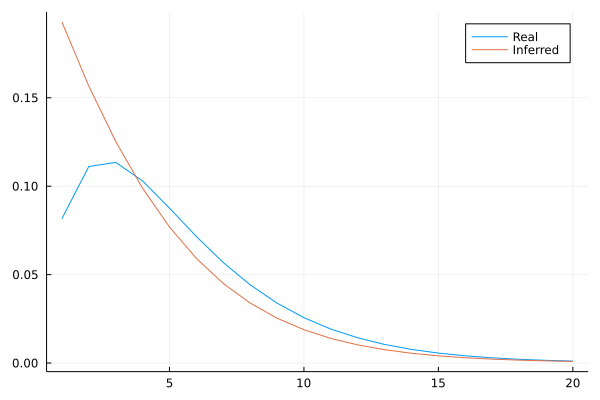

In [418]:
using Plots
inferred_inf = GaussianRate(MSI.θgen[5], MSI.θgen[6] , MSI.θgen[7])

real_trans = [rate_inf * rate_lat * exp(-(rate_inf+rate_rec)*t) *(exp((rate_inf-rate_lat+rate_rec)*t) - 1)/(rate_inf-rate_lat+rate_rec) for t=1:T]
inferred_trans=[Causality.density(inferred_inf,t) * exp(-Causality.cumulated(inferred_inf,t)) for t=1:T];

plot(real_trans, label = "Real")
plot!(inferred_trans,label="Inferred")
#savefig("comparisonHyperparams.pdf")

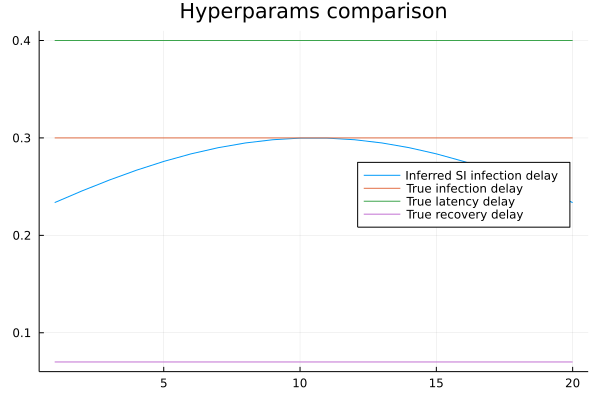

In [419]:
using Plots
x = LinRange(0,T,Int(T))
gauss(a,b,c,x) = a .* exp.(-((x .- b)/c) .^ 2)
plot(gauss(MSI.θgen[5], MSI.θgen[6] , MSI.θgen[7], x),label="Inferred SI infection delay",legend=:right,title="Hyperparams comparison")
plot!(gauss(inf_out.a,inf_out.b,inf_out.c,x),label="True infection delay")
plot!(gauss(l_delay.a, l_delay.b, l_delay.c,x),label="True latency delay ")
plot!(gauss(r_delay.a, r_delay.b, r_delay.c,x),label="True recovery delay ")
#plot!(gauss(0.47, 8., sqrt(3.56),x),label="True latency delay ")
#plot!(gauss(0.23, 16., sqrt(6.),x),label="True recovery delay ")
#savefig("Hyperparams_SEIRvsSI")

## Marginals and ROC curve

In [420]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i,1] .< t ) / numsamp
end

function marginalSI(i, t, stats)
    numsamp = size(stats,1)
    sum( stats[:,i] .< t ) / numsamp
end


function tpr(xtrue, rank) 
    den = sum(xtrue[rank])
    if den != 0
        return cumsum(xtrue[rank]) ./ den
    else
        return ones(size(rank))
    end
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

In [421]:
xtrue

100×3 Matrix{Float64}:
  4.64097   6.41536   19.8259
 20.0      20.0       20.0
 20.0      20.0       20.0
  5.57593   7.16263   17.3295
  7.66265   7.77203   12.9445
 14.6764   14.739     20.0
 10.1442   14.3428    18.9674
 20.0      20.0       20.0
  0.0       0.735106  20.0
 12.4514   16.0267    17.1482
 14.2768   17.1655    20.0
 20.0      20.0       20.0
 20.0      20.0       20.0
  ⋮                   
 20.0      20.0       20.0
 20.0      20.0       20.0
 20.0      20.0       20.0
 12.3316   12.4827    14.447
 20.0      20.0       20.0
 20.0      20.0       20.0
 11.111    16.3886    20.0
  3.958     4.93047   17.7051
 20.0      20.0       20.0
 20.0      20.0       20.0
 13.4563   15.8666    20.0
  0.0       3.53679   10.0494

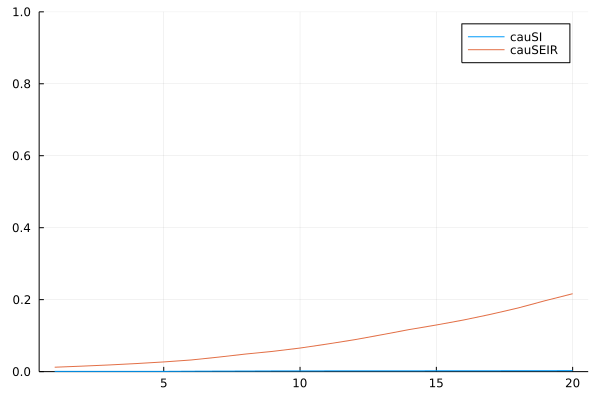

In [422]:
using Plots
p_cauSEIR = zeros(N,Int(T))
p_cauSI = zeros(N,Int(T))
for i = 1:N
    for t = 1:Int(T)
       p_cauSEIR[i,t] = marginal(i, t, statscauSEIR)
       p_cauSI[i,t] = marginalSI(i, t, statscauSI)
    end
end
i = 1
plot(p_cauSI[i,1:end], label = "cauSI")
plot!(p_cauSEIR[i,1:end], label = "cauSEIR")
#savefig("SEIRmarkov.pdf")
ylims!(0,1)

In [423]:
O

1-element Vector{Tuple{Int64, Int64, Int64, Float64}}:
 (1, 0, 20, 1.0e-6)

In [424]:
[o for o in O if o[1] == 12]

Tuple{Int64, Int64, Int64, Float64}[]

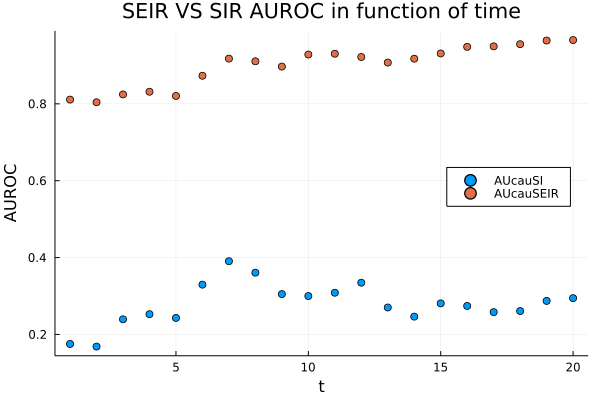

In [426]:
T = Int(T)
AU_cauSEIR=zeros(T)
AU_cauSI=zeros(T)
for t = 1:T
    cauSEIR_risk=zeros(N)
    cauSI_risk=zeros(N)
    for i=1:N
       cauSEIR_risk[i] = marginal(i,t,statscauSEIR)
       cauSI_risk[i] = marginalSI(i,t,statscauSI)
    end
    xt = xtrue[:,1] .< t-1e-3 
    AU_cauSEIR[t] = AUROC(ROC(xt, cauSEIR_risk))
    AU_cauSI[t] = AUROC(ROC(xt, cauSI_risk))
end

scatter(LinRange(1,T,T),AU_cauSI, label="AUcauSI",legend=:right)
scatter!(LinRange(1,T,T),AU_cauSEIR, label="AUcauSEIR", title="SEIR VS SIR AUROC in function of time")

T = Float64(T)
#ylims!(0.5,1.05)
savefig("SierologicalAUROC")
xlabel!("t")
ylabel!("AUROC")